In [1]:
%matplotlib inline

import cv2
import glob

import numpy as np
import matplotlib.pyplot as plt

In [2]:
nx = 9
ny = 6

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

objpoints = [] 
imgpoints = []

mtx = None
dist = None

In [42]:
def camera_calibration():
    img_list = glob.glob('camera_cal/*.jpg')
    
    for path in img_list:
        img = cv2.imread(path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    img = cv2.imread('test_images/straight_lines2.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_size = (img.shape[1], img.shape[0])

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return (mtx, dist)


def process(img, mtx, dist, sobel_kernel=3, s_thresh = (170, 255)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.undistort(img, mtx, dist)
    
    # combined thresh
    color_thresh, thresh, (gradx, channel_binary) = combined_thresh(img, sobel_kernel=sobel_kernel, dir_kernel=15,
                                                sobel_thesh=(50, 255), mag_thresh=(50, 255), dir_thresh=(0.7, 1.3))
    
    
    return img, color_thresh, thresh, gradx, channel_binary

def combined_thresh(img, sobel_kernel=3, dir_kernel=15, sobel_thesh=(20, 100), mag_thresh=(30, 100), dir_thresh=(0.7, 1.3),
                    s_thresh=(170, 255), l_thresh=(225, 255), b_thresh=(155, 200)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    
    # abs sobel thresh
    gradx = abs_sobel_thresh(gray, orient='x')
    
    #grady = abs_sobel_thresh(gray, orient='y')
    
    abs_binary = np.zeros_like(gradx)
    abs_binary[(gradx == 1)] = 1
    """
    # mag thresh
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobelxy = np.sqrt(sobelx**2 + sobely**2)
    scaled = np.uint8(255*(sobelxy / np.max(sobelxy)))

    mag_binary = np.zeros_like(scaled)
    mag_binary[(scaled >= mag_thresh[0]) & (scaled <= mag_thresh[1])] = 1
    
    # dir thresh
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=dir_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=dir_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1
    
    # combine mag binary and dir binary
    mag_dir_binary = np.zeros_like(mag_binary)
    mag_dir_binary[(mag_binary == 1) & (dir_binary == 1)] = 1
    
    # colored binary
    color_binary = np.dstack((gradx, abs_binary, mag_dir_binary)) * 255
    """
    
    # S channel
    S = hls[:, :, 2]
    s_binary = np.zeros_like(S)
    s_binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    # L channel
    L = luv[:, :, 0]
    l_binary = np.zeros_like(L)
    l_binary[(L > l_thresh[0]) & (L <= l_thresh[1])] = 1
    
    # b channel
    b = lab[:, :, 2]
    b_binary = np.zeros_like(b)
    b_binary[(b > b_thresh[0]) & (b <= b_thresh[1])] = 1
    
    channel_binary = np.zeros_like(s_binary)
    channel_binary[(s_binary == 1) | (l_binary == 1) | (b_binary == 1)] = 1
    
    # combined binary
    combined_binary = np.zeros_like(abs_binary)
    combined_binary[(abs_binary == 1) | (channel_binary == 1)] = 1
    
    color_binary = np.dstack((np.zeros_like(abs_binary), abs_binary, channel_binary)) * 255    
    
    return color_binary, combined_binary, (abs_binary, channel_binary)

def abs_sobel_thresh(gray, orient='x', thresh=(20, 100)):
    
    if orient == 'x':
        abs_sobelx = np.abs(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    else:
        abs_sobelx = np.abs(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    binary = np.zeros_like(scaled)
    binary[(scaled > thresh[0]) & (scaled <= thresh[1])] = 1
    
    
    return binary

def get_perspective_M(src, dst):
    warp_M = cv2.getPerspectiveTransform(src, dst)
    unwarp_M = cv2.getPerspectiveTransform(dst, src)
    return warp_M, unwarp_M

def warp(img, src, M):

    focus = np.copy(img)
    if len(focus.shape) == 2:
        focus = np.dstack([focus, focus, focus]) * 255
    focus = cv2.polylines(focus, np.int32([src]), 1, (255, 0, 0))

    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return focus, warped

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_line(warped):
    warped = warped * 255
    # window settings
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 40 # How much to slide left and right for searching
        
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        
        detected_line = np.zeros_like(warped)
        detected_line[(warped == 255) & (template == 255)] = 255
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
        
        middle = int(detected_line.shape[1]/2)
        left_detected = detected_line[:,:middle].nonzero()
        right_detected = detected_line[:,middle:].nonzero()

        ploty = np.linspace(0, detected_line.shape[0]-1, num=detected_line.shape[0])
        left_fit = np.polyfit(left_detected[0], left_detected[1], 2)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fit = np.polyfit(right_detected[0], (middle + right_detected[1]), 2)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    
    return output, detected_line, left_fit, right_fit

def fit_line(warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # If we don't find enough relevant points, return all None (this means error)
    min_inds = 10
    if lefty.shape[0] < min_inds or righty.shape[0] < min_inds:
        return None

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return result

def calculate_curvature(left_fit, right_fit, img):
    ym_px = 30 / 720 # Real world metres per y pixel
    xm_px = 3.7 / 700 # Real world metres per x pixel   

    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    left_fit_cr = np.polyfit(ploty * ym_px, left_fitx * xm_px, 2)
    right_fit_cr = np.polyfit(ploty * ym_px, right_fitx * xm_px, 2)
    
    left_curverad = ((1 + (2 * left_fit_cr[0] * np.max(ploty) * ym_px + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * np.max(ploty) * ym_px + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])
    return left_curverad, right_curverad

def plot_lane_area(left_fit, right_fit, M, img):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    # get poly coordinate
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    
    area = np.zeros_like(img).astype(np.uint8)
    cv2.fillPoly(area, np.int_([pts]), (0,255, 0))
    
    # unwarp 
    area = cv2.warpPerspective(area, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    
    # add area to image
    result = cv2.addWeighted(img, 1, area, 0.3, 0)
    return result

def calculate_offset(left_fit, right_fit):
    lane_width = 3.7 / 300
    height, width = (720, 1280)
    
    left_point = left_fit[0] * height ** 2 + left_fit[1] * height + left_fit[2]
    right_point = right_fit[0] * height ** 2 + right_fit[1] * height + right_fit[2]
    mid_point = np.mean([left_point, right_point])
    
    offset = ((width / 2) - mid_point) * lane_width

    return offset

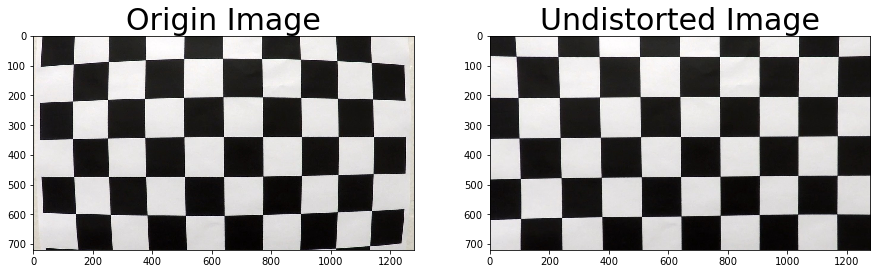

In [23]:
mtx, dist = camera_calibration()
cal = cv2.imread('camera_cal/calibration1.jpg')

cal_undistort, _, _, _, _ = process(cal, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.imshow(cv2.cvtColor(cal, cv2.COLOR_BGR2RGB))
ax1.set_title('Origin Image', fontsize=30)
ax2.imshow(cal_undistort)
ax2.set_title('Undistorted Image', fontsize=30)

f.savefig('examples/undistort.png')

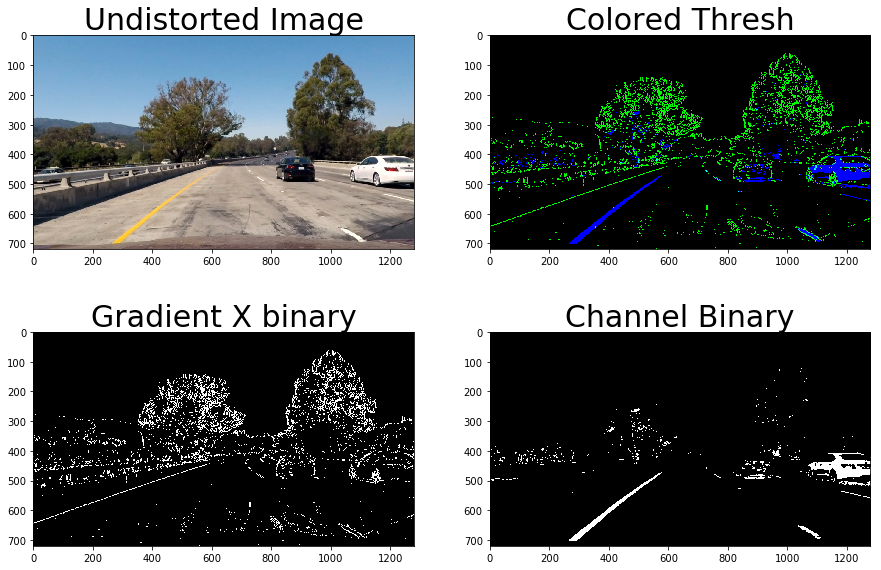

In [38]:
#img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.imread('test_images/test1.jpg')

undistort, color_thresh, thresh, gradx, channel_binary = process(img, mtx, dist, sobel_kernel=7)


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
ax1.imshow(undistort)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(color_thresh)
ax2.set_title('Colored Thresh', fontsize=30)

ax3.imshow(gradx, cmap='gray')
ax3.set_title('Gradient X binary', fontsize=30)
ax4.imshow(channel_binary, cmap='gray')
ax4.set_title('Channel Binary', fontsize=30)


f.savefig('examples/thresh.png')

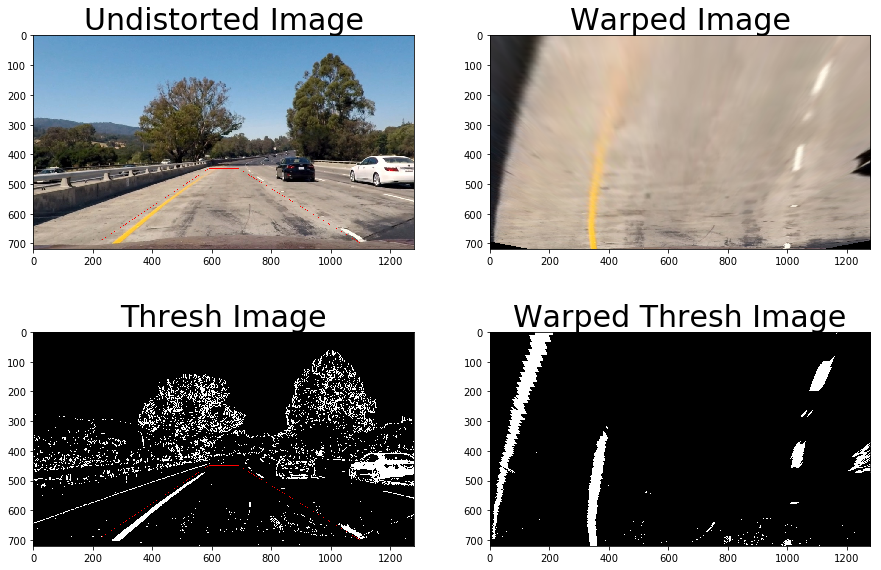

In [39]:
img_size = (img.shape[1], img.shape[0])
offset = 300
src = np.float32([[215, 700], [590, 450], [690, 450], [1100, 700]])
dst = np.float32([[offset, img_size[1]],
                    [offset, 0],
                    [img_size[0]-offset, 0], 
                    [img_size[0]-offset, img_size[1]]])

warp_M, unwarp_M = get_perspective_M(src, dst)


focus, warped = warp(undistort, src, warp_M)
thresh, warped_line = warp(thresh, src, warp_M)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
ax1.imshow(focus)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=30)

ax3.imshow(thresh)
ax3.set_title('Thresh Image', fontsize=30)
ax4.imshow(warped_line, cmap='gray')
ax4.set_title('Warped Thresh Image', fontsize=30)
f.savefig('examples/warp.png')

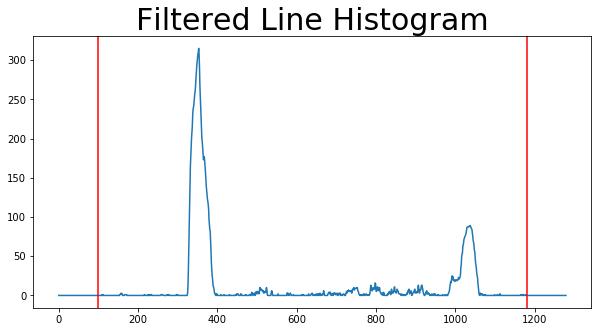

In [40]:
histogram = np.sum(warped_line[warped_line.shape[0]//2:,:], axis=0)

# filtering values of both sides
ignore = 100
histogram[0:ignore] = 0
histogram[histogram.shape[0]-ignore:] = 0

y_max = np.max(histogram)

f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(histogram)
ax.axvline(x=ignore, color='r')
ax.axvline(x=histogram.shape[0]-ignore, color='r')
ax.set_title("Filtered Line Histogram", fontsize=30)
f.savefig('examples/line_histogram.png')

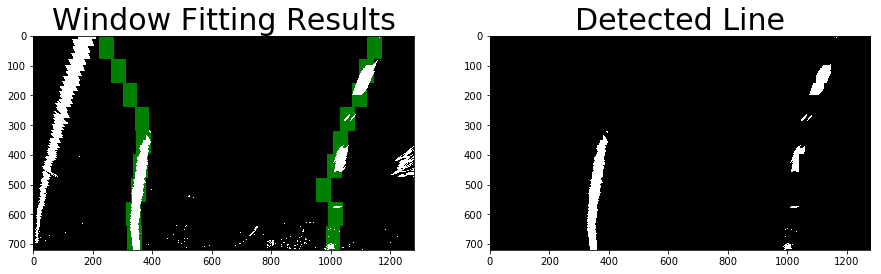

In [43]:
line_window, detected, left_fit, right_fit = find_line(warped_line)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.imshow(line_window)
ax1.set_title("Window Fitting Results", fontsize=30)

ax2.imshow(detected, cmap='gray')
ax2.set_title("Detected Line", fontsize=30)
f.savefig('examples/window_fitting.png')

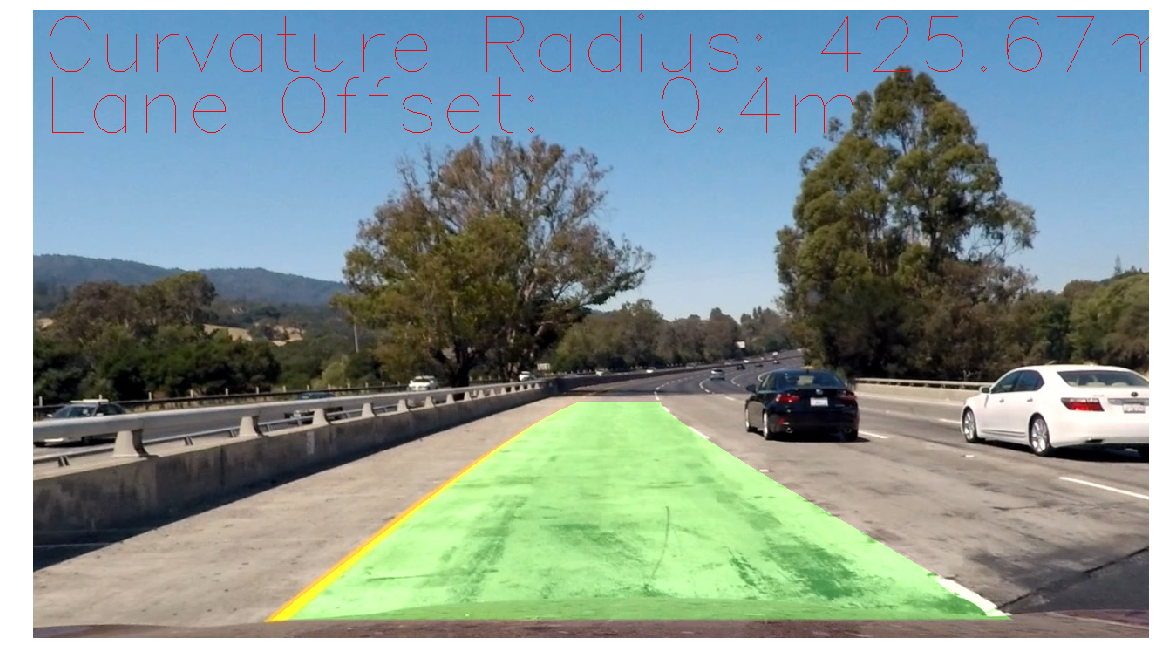

In [44]:
left_rad, right_rad = calculate_curvature(left_fit, right_fit, detected)
rad = np.mean([left_rad, right_rad])
offset = calculate_offset(left_fit, right_fit)
result = plot_lane_area(left_fit, right_fit, unwarp_M, undistort)
cv2.putText(result, 'Curvature Radius: {}m'.format(round(rad, 2)), (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 3, 255)
cv2.putText(result, 'Lane Offset: {}m'.format(round(offset, 2)), (10, 140), cv2.FONT_HERSHEY_SIMPLEX, 3, 255)

f, ax = plt.subplots(1, 1, figsize=(20, 15))
ax.imshow(result)
#ax.set_title("Result", fontsize=30)
ax.axis('off')
f.savefig('examples/output.png', bbox_inches='tight')